# Deep learning for force prediction during motion

### importing libraries

In [28]:
import pandas as pd
import kerastuner
import sys
import scipy as sp
from scipy import interpolate
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import ProgbarLogger
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import glob
import kerastuner as kt
from kerastuner.tuners import RandomSearch
from numpy import genfromtxt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from tensorboard.plugins.hparams import api as hp

%matplotlib inline

### dataset handling

In [14]:
#initiate path of datafile
path = r'C:\Users\xatzo\LocalDisk\Data'  

#put all files together
all_files = glob.glob(os.path.join(path, "*.csv"))# advisable to use os.path.join,make concatenation OS independent

#specify the length for interpolation
new_length = 100

#dataframes final
dataframes=np.zeros((1101,100,28))
target_fx=np.zeros((1101,100,1))
target_fy=np.zeros((1101,100,1))
target_fz=np.zeros((1101,100,1))

for i,f in enumerate(all_files):
    print(i)
    df= pd.read_csv(f)
    
    #drop bad columns - CHECK
    df=df.drop(df.loc[:,['med_cond_adduction_r','lat_cond_adduction_r','mtp_angle_r','med_cond_adduction_l',
                        'lat_cond_adduction_l','mtp_angle_l','lat_cond_joint_r_on_lat_cond_r_in_lat_cond_r_fx']],axis=1)
    df=df.drop(df.iloc[:,[0]],axis=1)
    
    #interpolation
    x = np.array(range(0,len(df)))
    y = df.values
    new_x = np.linspace(0, len(df)-1, new_length)
    kin = pd.DataFrame(sp.interpolate.interp1d(x, y, axis=0, kind='quadratic')(new_x),columns=df.columns)
    kin=(kin-kin.min())/(kin.max()-kin.min())
    
    #creating target and training
    kin_target_fx=kin[['med_cond_joint_r_on_med_cond_r_in_med_cond_r_fx']]
    kin_target_fy=kin[['med_cond_joint_r_on_med_cond_r_in_med_cond_r_fy']]
    kin_target_fz=kin[['med_cond_joint_r_on_med_cond_r_in_med_cond_r_fz']]
    kin_input=kin.drop(kin[['med_cond_joint_r_on_med_cond_r_in_med_cond_r_fx',
    'med_cond_joint_r_on_med_cond_r_in_med_cond_r_fy','med_cond_joint_r_on_med_cond_r_in_med_cond_r_fz']],axis=1)
    
    for j in range(100):
        for k in range(28):
                dataframes[i,j,k]=kin_input.iloc[j][k]
        target_fx[i,j,0]=kin_target_fx.iloc[j][0]
        target_fy[i,j,0]=kin_target_fy.iloc[j][0]
        target_fz[i,j,0]=kin_target_fz.iloc[j][0]

0
1
2
3
4


KeyboardInterrupt: 

### write into csv files

In [22]:
dataframes2=np.reshape(dataframes,(110100,28))
np.savetxt("dataframes.csv", dataframes2, delimiter=",")
target_fx2=np.reshape(target_fx,(110100,1))
np.savetxt("target_fx.csv", target_fx2, delimiter=",")
target_fy2=np.reshape(target_fy,(110100,1))
np.savetxt("target_fy.csv", target_fy2, delimiter=",")
target_fz2=np.reshape(target_fz,(110100,1))
np.savetxt("target_fz.csv", target_fz2, delimiter=",")

ValueError: cannot reshape array of size 1 into shape (110100,1)

### read from csv files

In [6]:
dataframes = genfromtxt('dataframes.csv', delimiter=',')
target_fx = genfromtxt('target_fx.csv', delimiter=',')
target_fy = genfromtxt('target_fx.csv', delimiter=',')
target_fz = genfromtxt('target_fx.csv', delimiter=',')

### reshape back

In [7]:
np.array(dataframes)
dataframes=np.reshape(dataframes,(1101,100,28))
np.array(target_fx)
target_fx=np.reshape(target_fx,(1101,100,1))
np.array(target_fy)
target_fy=np.reshape(target_fy,(1101,100,1))
np.array(target_fx)
target_fz=np.reshape(target_fz,(1101,100,1))

shuffling

In [8]:
np.random.shuffle(dataframes)
print(np.shape(dataframes))
np.random.shuffle(target_fx)
np.random.shuffle(target_fy)
np.random.shuffle(target_fz)

(1101, 100, 28)


Smoothing

In [9]:
fit_data = sp.ndimage.gaussian_filter(dataframes,sigma=(0,20,0))

## deep learning model

In [27]:
#building model
def build_model():
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(100,28)))
    model.add(layers.Dense(28,activation = 'relu'))
    model.add(BatchNormalization(momentum = 0.99))
    model.add(Dropout(0.1))
    model.add(layers.Conv1D(filters=16,kernel_size=3,strides=1,padding='same',activation='relu'))
    model.add(BatchNormalization(momentum = 0.99))
    model.add(Dropout(0.1))
    model.add(layers.Conv1D(filters=32,kernel_size=3,strides=1,padding='same',activation='relu'))
    model.add(BatchNormalization(momentum = 0.99))
    model.add(Dropout(0.1))
    model.add(layers.Conv1D(filters=64,kernel_size=3,strides=1,padding='same',activation='relu'))
    model.add(BatchNormalization(momentum = 0.99))
    model.add(Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(layers.Dense(1, activation = 'linear'))
    
    model.compile(
        optimizer='adam',
        loss=['mean_squared_error'],
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model


count=0
checkpoint_path = "C:/Users/xatzo/Desktop/StoreWeight/cv_force_X"+str(count)+".ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)
    
for train_index,test_index in KFold(3).split(dataframes):
    count+=1
    print(count)
    checkpoint_path = "C:/Users/xatzo/Desktop/StoreWeight/cv"+str(count)+".ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)
    x_train,x_test=dataframes[train_index,:,:],dataframes[test_index,:,:]
    y_train,y_test=target_fx[train_index,:,:],target_fx[test_index,:,:]
    
    
    model = build_model()
    model = MODEL
    
    

    #train model and output
    history = model.fit(
        x_train,
        y_train,
        epochs=200,
        validation_data=(
            x_test,
            y_test),
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            min_delta=0.00001,
            patience = 5),
            ProgbarLogger(count_mode='samples',stateful_metrics=None)
                   ,cp_callback
        ]
    )

    predict_n = model.predict(x_test)
    predict_n = predict_n.astype(np.float64)
    corr_value, p_value = pearsonr(predict_n.ravel(), y_test.ravel())   
    print(corr_value,round(p_value,4))
    print("correlation:"+str(corr_value)+" p_value:"+str(p_value))
    fig = plt.figure(figsize=(20, 20))
    plot_corr(y_test.ravel(), predict_n.ravel(),corr_value)

1


AttributeError: 'list' object has no attribute 'fit'

In [12]:
#model.summary()
#print(predict_n)
print(np.shape(predict_n))
print(np.shape(y_test))
print(predict_n.dtype)
print(y_test.dtype)

(367, 100, 1)
(367, 100, 1)
float64
float64


# Corr-calcs

In [13]:
predict_n=np.reshape(predict_n,(36700,3,3))
val_d=np.reshape(val_d,(36700,3,3))

corrs=np.zeros((3,3))
p_s=np.zeros((3,3))

for i in range(3):
    for j in range(3):
        corr_value, p_value = pearsonr(predict_n[:,i,j], val_d[:,i,j])   
        print(corr_value,round(p_value,4))
        corrs[i,j]=corr_value
        p_s[i,j]=p_value
        
        ax = fig.add_subplot(33+(i+j+1))
        plot_corr(val_d[:,i,j], predict_n[:,i,j],corrs[i,j])

ValueError: cannot reshape array of size 36700 into shape (36700,3,3)

## plot corr

In [14]:
def plot_corr(a,b,c):
    m, cept =np.polyfit(a,b,1)
    x = np.arange(0,1,0.02)
    plt.scatter(a, b, marker='o',s=1, c='blue' )
    plt.scatter(x, m*x + cept, c='red')
    plt.xlabel('actual values')
    plt.ylabel('predicted values')
    c=round(c,4)
    plt.title('Pearson correlation ='+str(c))  
    plt.legend(loc='lower right')

In [15]:
sys.version

'3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]'

## Hyperparameter tuning

INFO:tensorflow:Reloading Oracle from existing project my_dir\helloworld\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\helloworld\tuner0.json
INFO:tensorflow:Oracle triggered exit


366/366 [==============================] - ETA: 2s - loss: 0.0606 - root_mean_squared_error: 0.246 - ETA: 0s - loss: 0.0548 - root_mean_squared_error: 0.234 - 0s 1ms/sample - loss: 0.0554 - root_mean_squared_error: 0.2353
Train on 734 samples, validate on 366 samples
Epoch 1/200
Epoch 1/200
734/734 [==============================] - ETA: 37s - loss: 0.0538 - root_mean_squared_error: 0.2319 - ETA: 37s - loss: 0.0538 - root_mean_squared_error: 0.23 - ETA: 18s - loss: 0.0534 - root_mean_squared_error: 0.23 - ETA: 18s - loss: 0.0534 - root_mean_squared_error: 0.23 - ETA: 12s - loss: 0.0561 - root_mean_squared_error: 0.23 - ETA: 12s - loss: 0.0561 - root_mean_squared_error: 0.23 - ETA: 9s - loss: 0.0566 - root_mean_squared_error: 0.237 - ETA: 9s - loss: 0.0566 - root_mean_squared_error: 0.2379 - ETA: 7s - loss: 0.0587 - root_mean_squared_error: 0.242 - ETA: 7s - loss: 0.0587 - root_mean_squared_error: 0.242 - ETA: 6s - loss: 0.0593 - root_mean_squared_error: 0.243 - ETA: 6s - loss: 0.0593 -

734/734 [==============================] - ETA: 2s - loss: 0.0728 - root_mean_squared_error: 0.2699 - ETA: 2s - loss: 0.0728 - root_mean_squared_error: 0.269 - ETA: 2s - loss: 0.0642 - root_mean_squared_error: 0.253 - ETA: 2s - loss: 0.0642 - root_mean_squared_error: 0.253 - ETA: 2s - loss: 0.0635 - root_mean_squared_error: 0.251 - ETA: 2s - loss: 0.0635 - root_mean_squared_error: 0.251 - ETA: 1s - loss: 0.0621 - root_mean_squared_error: 0.249 - ETA: 1s - loss: 0.0621 - root_mean_squared_error: 0.249 - ETA: 1s - loss: 0.0615 - root_mean_squared_error: 0.248 - ETA: 1s - loss: 0.0615 - root_mean_squared_error: 0.248 - ETA: 1s - loss: 0.0612 - root_mean_squared_error: 0.247 - ETA: 1s - loss: 0.0612 - root_mean_squared_error: 0.247 - ETA: 1s - loss: 0.0628 - root_mean_squared_error: 0.250 - ETA: 1s - loss: 0.0628 - root_mean_squared_error: 0.250 - ETA: 1s - loss: 0.0613 - root_mean_squared_error: 0.247 - ETA: 1s - loss: 0.0613 - root_mean_squared_error: 0.247 - ETA: 1s - loss: 0.0605 - roo

No handles with labels found to put in legend.


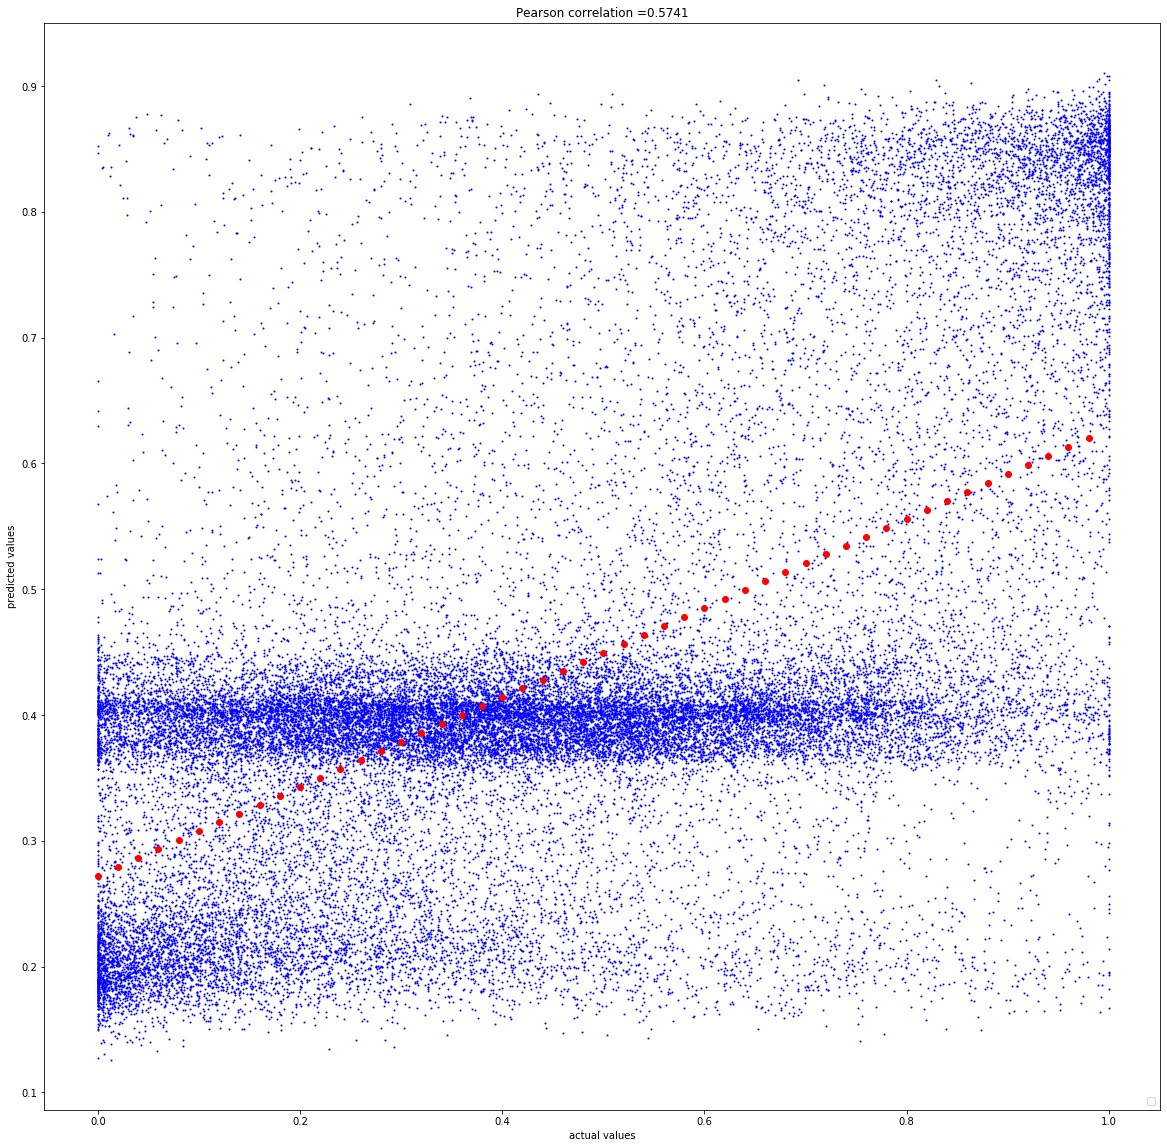

In [33]:
def build_model_test(hp):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(100,28)))
    model.add(layers.Dense(28,activation = 'relu'))
    model.add(BatchNormalization(momentum = 0.99))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)))
    model.add(layers.Conv1D(filters=hp.Int(
    'num_filters',
    16, 128,
    step=16
),kernel_size=3,strides=1,padding='same',activation='relu'))
    model.add(BatchNormalization(momentum = 0.99))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)))
    model.add(layers.Conv1D(filters=hp.Int(
    'num_filters',
    16, 128,
    step=16
),kernel_size=3,strides=1,padding='same',activation='relu'))
    model.add(BatchNormalization(momentum = 0.99))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)))
    model.add(layers.Conv1D(filters=hp.Int(
    'num_filters',
    16, 128,
    step=16
),kernel_size=3,strides=1,padding='same',activation='relu'))
    model.add(BatchNormalization(momentum = 0.99))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)))
    model.add(layers.Dense(units=hp.Int('units',min_value=16,max_value=512,step=32,default=128),activation = 'relu'))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)))
    model.add(layers.Dense(1, activation = 'linear'))
    
    model.compile(
        optimizer='adam',
        loss=['mean_squared_error'],
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model
              
tuner = RandomSearch(
    build_model_test,
    objective=kerastuner.Objective("val_root_mean_squared_error", direction="min"),
    max_trials=20,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld')
             
              
x_train,x_test=dataframes[0:734,:,:],dataframes[734:1100,:,:]
y_train,y_test=target_fx[0:734,:,:],target_fx[734:1100,:,:]
              

    
tuner.search(x_train, y_train,
             epochs=20,
             validation_data=(x_test, y_test))
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_test, y_test)

MODEL = tuner.get_best_models(num_models=1)
model = MODEL



history = best_model.fit(
        x_train,
        y_train,
        epochs=200,
        validation_data=(
            x_test,
            y_test),
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            min_delta=0.00001,
            patience = 5),
            ProgbarLogger(count_mode='samples',stateful_metrics=None)
                   ,cp_callback
        ]
    )

predict_n = best_model.predict(x_test)
predict_n = predict_n.astype(np.float64)
corr_value, p_value = pearsonr(predict_n.ravel(), y_test.ravel())   
print(corr_value,round(p_value,4))
print("correlation:"+str(corr_value)+" p_value:"+str(p_value))
fig = plt.figure(figsize=(20, 20))
plot_corr(y_test.ravel(), predict_n.ravel(),corr_value)

In [21]:
print(model)

In [22]:
model.summary()

AttributeError: 'list' object has no attribute 'summary'